# Decision Tree Lab

In [53]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from scipy import stats
import arff as arf
import math
import random

## Node Class

In [54]:
class Node:
  def __init__(self, inputs, outputs, counts, features_used=[]):
    self.inputs = inputs
    self.outputs = outputs
    self.counts = counts
    self.children = []
    self.features_used = features_used
    # initial info of each node
    self.info  = self.calc_info()
    # will be used for leaf nodes, all other nodes will have none
    self.prediction= None
    
  def generate_children(self):
    # indicating the number of columns
    for i in range(len(self.inputs[0])):
      # if we havent already split/seen this feature
      if i not in self.features_used:
        # initialize the next children for this node
        next_children = []
        # indicating the number of values for this feature
        for j in range(self.counts[i]):
          # initialize temp inputs and outputs. we will use these arrays to set as inputs and outputs for the next node
          tmp_inputs = []
          tmp_outputs = []
          # loop though all of the inputs to add to the tmp arrays
          for k in range(len(self.inputs)):
            # filtering the input values we are adding to tmp arrays
            if self.inputs[k][i] == j:
              tmp_inputs.append(self.inputs[k])
              tmp_outputs.append(self.outputs[k])
          # if there were inputs to add, create a new node
          if len(tmp_inputs) != 0:
            new_node = Node(tmp_inputs, tmp_outputs, self.counts, np.concatenate((self.features_used, [i])))
            # setting the feature and feature index, keeping track of where we are so we know where to go
            new_node.set_feature(j)
            new_node.set_feature_index(i)
            next_children.append(new_node)
        if len(self.children) == 0:
          self.children = next_children
        else:
          # get the current split info and next split info
          curr_split_gain = self.calc_children_info(self.children)
          next_split_gain = self.calc_children_info(next_children)
          # if there is more info gain on next split, split here with this nodes children
          if next_split_gain > curr_split_gain:
            self.children = next_children
    return self.calc_children_info(self.children)

  def calc_children_info(self, children):
    info = self.info
    for i in range(len(children)):
      info -= (len(children[i].inputs) / len(self.inputs) * children[i].get_info())
    return info
    
  def set_feature(self, num):
    self.feature = num
    return

  def set_feature_index(self, num):
    self.feature_index = num
    return

  def get_num_feat_used(self):
    return len(self.features_used)

  def predict_node(self):
    # if info is zero, prediction will be first index of nodes output array
    if self.get_info() == 0:
      self.prediction = self.outputs[0]
    else:
      self.prediction = stats.mode(self.inputs).mode[0][0]

  def get_children(self):
    return self.children

  def calc_info(self):
    info = 0
    # calculate information gained
    ent_arr = np.zeros(self.counts[-1])
    for i in range(len(self.outputs)):
      ent_arr[self.outputs[i]] += 1
    ent_arr = ent_arr / len(self.inputs)
    for child in ent_arr:
      if child != 0:
          info += (-child) * math.log(child, 2)
    if len(ent_arr) == 0:
      self.prediction = self.outputs[0]
    return info

  def get_info(self):
    return self.info

  def get_attr_index(self):
    return self.children_attr_index[self.index]

  # passing -1 for layer of root node
  def print_tree(self, layer):
    # need to print a indentation for the number of layer we are on
    for i in range(layer):
      print("   ",end="")
    # if we are passed the root node, print out the feature and feature index
    if layer >= 0:
      print('feature ', end="")
      print(self.feature_index, end="")
      print(' = ', end="")
      print(self.feature, end="")
      print(':')
    # if we are at a leaf node, print out the prediction
    if self.prediction != None:
      for i in range(layer+1):
        print("   ", end="")
      print('prediction: ' + str(self.prediction))
    else:
      # loop through all children and print out information
      num_ch = len(self.get_children())
      for i in range(num_ch):
        self.get_children()[i].print_tree(layer+1)
    return
    


## 1. (40%) Correctly implement the ID3 decision tree algorithm, including the ability to handle unknown attributes (You do not need to handle real valued attributes).  
### Code Requirements/Notes:
- Use standard information gain as your basic attribute evaluation metric.  (Note that normal ID3 would usually augment information gain with gain ratio or some other mechanism to penalize statistically insignificant attribute splits. Otherwise, even with approaches like pruning below, the SSE type of overfit could still hurt us.) 
- You are welcome to create other classes and/or functions in addition to the ones provided below. (e.g. If you build out a tree structure, you might create a node class).
- It is a good idea to use a simple data set (like the lenses data or the pizza homework), which you can check by hand, to test your algorithm to make sure that it is working correctly. 

In [55]:
class DTClassifier(BaseEstimator,ClassifierMixin):

    def __init__(self,counts=None):
        """ Initialize class with chosen hyperparameters.
        Args:
        Optional Args (Args we think will make your life easier):
            counts: A list of Ints that tell you how many types of each feature there are
        Example:
            DT  = DTClassifier()
            or
            DT = DTClassifier(count = [2,3,2,2])
            Dataset = 
            [[0,1,0,0],
            [1,2,1,1],
            [0,1,1,0],
            [1,2,0,1],
            [0,0,1,1]]

        """ 
        self.counts = counts
        # used to save info gain through the fit process
        self.info_gain =[]

    def print_tree(self):
        self.root_node.print_tree(-1)

    def split_and_fit(self, fullData):
        # split up targets and inputs
        train = np.array(fullData[:,0:-1])
        targets = np.array(fullData[:,-1])
        # fit data
        self.fit(train, targets)
        return

    def fit(self, X, y):
        """ Fit the data; Make the Decision tree

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 1D numpy array with the training targets

        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """
        # set number of features and root node class variables
        self.num_features = len(X[0])
        self.root_node = Node(X, y, self.counts, features_used=[])

        # start splitting the tree from root node
        self.split_tree(self.root_node)
        
        return self

    def split_tree(self, node):
        # how we know when we are done
        if node.get_info() != 0 and node.get_num_feat_used() < self.num_features:
            # get info gained at the split
            info = node.generate_children()
            self.info_gain.append(info)
            # get children of current node
            children = node.get_children()
            for i in range(len(children)):
                # loop through children to split tree
                if len(node.get_children()[i].inputs) != 0:
                    self.split_tree(node.get_children()[i])
        else:
            # at a leaf node, need to do prediction
            node.predict_node()
    
    def predict_helper(self, node, pattern):
        # BASE CASE- if we are at the leaf node return its prediction
        if node.prediction != None:
            return node.prediction
        else:
            children = node.get_children()
            feat_ind = children[0].feature_index
            pat_val = pattern[feat_ind]
            n_node = None
            for i in range(len(children)):
                if children[i].feature == pat_val:
                    n_node = children[i]
                    break
            # need to choose a random child node incase we aren't done yet
            if n_node == None:
                rand = random.randint(0, len(children) - 1)
                n_node = children[rand]
        # recursive call to traverse tree
        return self.predict_helper(n_node, pattern)


    def predict(self, X):
        """ Predict all classes for a dataset X

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets

        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        preds = []
        # append predictions of each row in x by traversing tree
        for i in range(len(X)):
            preds.append(self.predict_helper(self.root_node, X[i]))
        return preds


    def score(self, X, y):
        """ Return accuracy(Classification Acc) of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 1D numpy array of the targets 
        """
        # get predictions array
        predictions = self.predict(X)
        total = len(y)
        correct = 0
        # compare with actual outputs
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                correct +=1
        # return percentage correct
        return correct/total
        
    # returns array of info gain at each split 
    def get_split_info_gain(self):
        return self.info_gain



# Helper Functions

In [56]:
# HELPER FUNCTIONS

def convertBytestoString(df):
  for col in df:
    if isinstance(df[col][0], bytes):
      df[col] = df[col].str.decode("utf8")
  return df

def get_counts(dataset):
  counts = []
  for column in dataset:
    counts.append(len(dataset[column].value_counts()))
  return counts

def handle_missing(dataset):
  # calculate mode, replacing missing values with mode
  mode = dataset.mode().to_numpy().flatten()
  data_columns = len(dataset.columns.to_numpy())

  new_dataset = dataset.to_numpy()
  length = len(new_dataset)
  for i in range(length):
    # loop through columns looking for missing values
    for j in range(data_columns):
      # missing with question mark and np.nan
      if new_dataset[i][j] == '?' or new_dataset[i][j] == np.nan:
        new_dataset[i][j] = mode[j]
  return new_dataset

# Dataset Constants

In [57]:
# for cleaning lenses dataset
lenses_dict = {"age": {"young": 2, "pre_presbyopic": 1, "presbyopic": 0},
    "spectacle_prescrip": {"myope": 1, "hypermetrope": 0},
    "astigmatism": {"no": 0, "yes": 1},
    "tear_prod_rate" : {"reduced" : 1, "normal" : 0 },
    "contact_lenses" : {"none": 1, "soft": 2, "hard": 0}}

# for cleaning zoo dataset
zoo_dict = {"hair":     {"F": 0, "T": 1},
    "feathers": {"F": 0, "T": 1},
    "eggs": {"F": 0, "T": 1},
    "milk": {"F": 0, "T": 1},
    "airborne": {"F": 0, "T": 1},
    "predator": {"F": 0, "T": 1},
    "aquatic": {"F": 0, "T": 1},
    "toothed": {"F": 0, "T": 1},
    "backbone": {"F": 0, "T": 1},
    "breathes": {"F": 0, "T": 1},
    "venomous": {"F": 0, "T": 1},
    "fins": {"F": 0, "T": 1},
    "legs": {"0": 0, "2": 1, "4": 2, "5": 3, "6": 4, "8": 5},
    "tails": {"F": 0, "T": 1},
    "domestic": {"F": 0, "T": 1},
    "catsize": {"F": 0, "T": 1},
    "type": {"cT": 0, "c2": 1, "c3": 2, "c4": 3, "c5": 4, "c6": 5,"c7": 6}}

# for cleaning cars dataset
cars_dict = {"buying": {"vhigh": 0, "high": 1, "med": 2, "low": 3},
    "maint": {"vhigh": 0, "high": 1, "med": 2, "low": 3},
    "doors": {"2": 0, "3": 1, "4": 2, "5more": 3},
    "persons": {"2": 0, "4": 1, "more": 2},
    "lug_boot": {"small": 0, "med": 1, "big": 2},
    "safety": {"low": 0, "med": 1, "high": 2},
    "class": {"unacc": 0, "acc": 1, "good": 2, "vgood": 3}}

car_columns = ["buying","maint", "doors", "persons", "lug_boot", "safety", "class"]

# for cleaning voting dataset
voting_dict = {'handicapped-infants': { 'n':0, 'y':1},
                'water-project-cost-sharing' : { 'n':0, 'y':1},
                'adoption-of-the-budget-resolution' : { 'n':0, 'y':1},
                'physician-fee-freeze' : { 'n':0, 'y':1},
                'el-salvador-aid' : { 'n':0, 'y':1},
                'religious-groups-in-schools': { 'n':0, 'y':1},
                'anti-satellite-test-ban' : { 'n':0, 'y':1},
                'aid-to-nicaraguan-contras' : { 'n':0, 'y':1},
                'mx-missile' : { 'n':0, 'y':1},
                'immigration' : { 'n':0, 'y':1},
                'synfuels-corporation-cutback' : { 'n':0, 'y':1},
                'education-spending' : { 'n':0, 'y':1},
                'superfund-right-to-sue' : { 'n':0, 'y':1},
                'crime' : { 'n':0, 'y':1},
                'duty-free-exports' : { 'n':0, 'y':1},
                'export-administration-act-south-africa' : { 'n':0, 'y':1},
                'Class' : { 'democrat':0, 'republican':1}}
    

## 1.1 Debug

Debug your model by training on the lenses dataset: [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff)

Test your model on the lenses test set: [Debug Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff)

Parameters:
(optional) counts = [3,2,2,2] (You should compute this when you read in the data, before fitting)

---

Expected Results: Accuracy = [0.33]

Predictions should match this file: [Lenses Predictions](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv)

*NOTE: The [Lenses Prediction](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/pred_lenses.csv) uses the following encoding: soft=2, hard=0, none=1. If your encoding is different, then your output will be different, but not necessarily incorrect.*

Split Information Gains (These do not need to be in this exact order):

[0.5487949406953987, 0.7704260414863775, 0.3166890883150208, 1.0, 0.4591479170272447, 0.9182958340544894]

<!-- You should be able to get about 68% (61%-82%) predictive accuracy on the lenses data -->

Here's what your decision tree splits should look like, and the corresponding child node predictions:

Decision Tree:
<pre>
tear_prod_rate = normal:
    astigmatism = no:
        age = pre_presbyopic:
            prediction: soft
        age = presbyopic:
            spectacle_prescrip = hypermetrope:
                prediction: soft
            spectacle_prescrip = myope:
                prediction: none
        age = young:
            prediction: soft
    astigmatism = yes:
        spectacle_prescrip = hypermetrope:
            age = pre_presbyopic:
                prediction: none
            age = presbyopic:
                prediction: none
            age = young:
                prediction: hard
        spectacle_prescrip = myope:
            prediction: hard
tear_prod_rate = reduced:
    prediction: none
</pre>

In [58]:
# Load debug training data 
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses.arff --output lenses.arff
    
debug_data = arff.loadarff('lenses.arff')
lenses_df = pd.DataFrame(debug_data[0])
lenses_df = convertBytestoString(lenses_df)
lenses_df = lenses_df.replace(lenses_dict)

lenses_np = lenses_df.to_numpy()
counts = get_counts(lenses_df)

# Train Decision Tree
clf = DTClassifier(counts=counts)
acc = clf.split_and_fit(lenses_np)
clf.print_tree()
print("\n")


# Load debug test data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/lenses_test.arff --output debug_test.arff

debug_test = arff.loadarff('debug_test.arff')
debug_test_df = pd.DataFrame(debug_test[0])

lenses_test_df = convertBytestoString(debug_test_df)
lenses_test_df = lenses_test_df.replace(lenses_dict)

# Convert to numpy
lenses_np_test = lenses_test_df.to_numpy()

# Predict and compute model accuracy
prediction = clf.predict(lenses_np_test[:,0:len(counts)-1])
acc = clf.score(lenses_np_test[:,0:], lenses_np_test[:,len(counts)-1:])
print("acc: ", acc, "\n")

# Print the information gain of every split you make.
print("Split info gain")
print(clf.get_split_info_gain())


feature 3 = 0:
   feature 2 = 0:
      feature 0 = 0:
         feature 1 = 0:
            prediction: 2
         feature 1 = 1:
            prediction: 1
      feature 0 = 1:
         prediction: 2
      feature 0 = 2:
         prediction: 2
   feature 2 = 1:
      feature 1 = 0:
         feature 0 = 0:
            prediction: 1
         feature 0 = 1:
            prediction: 1
         feature 0 = 2:
            prediction: 0
      feature 1 = 1:
         prediction: 0
feature 3 = 1:
   prediction: 1


acc:  0.3333333333333333 

Split info gain
[0.5487949406953985, 0.7704260414863777, 0.3166890883150208, 1.0, 0.4591479170272448, 0.9182958340544896]


## 1.2 Evaluation

We will evaluate your model based on its performance on the zoo dataset. 

Train your model using this dataset: [Evaluation Train Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff)

Test your model on this dataset: [Evaluation Test Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff)

Parameters:
(optional) counts = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2] (You should compute this when you read in the data, before fitting)

---
Print out your accuracy on the evaluation test dataset.

Print out the information gain of every split you make.

In [59]:
# Load evaluation training data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo.arff --output zoo.arff
    
eval_data = arff.loadarff('zoo.arff')
eval_df = pd.DataFrame(eval_data[0])
eval_df = convertBytestoString(eval_df)
eval_df = eval_df.replace(zoo_dict)
eval_np = eval_df.to_numpy()
counts = get_counts(eval_df)

# Train Decision Tree
eval_clf = DTClassifier(counts=counts)
eval_acc = eval_clf.split_and_fit(eval_np)
eval_clf.print_tree()
print("\n")


# Load debug test data
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/zoo_test.arff --output eval_test.arff

eval_test = arff.loadarff('eval_test.arff')
eval_test_df = pd.DataFrame(eval_test[0])

eval_test_df = convertBytestoString(eval_test_df)
eval_test_df = eval_test_df.replace(zoo_dict)

eval_np_test = eval_test_df.to_numpy()

# Predict and compute model accuracy
prediction = eval_clf.predict(eval_np_test[:,0:len(counts)-1])
acc = eval_clf.score(eval_np_test[:,0:], eval_np_test[:,len(counts)-1:])
print("acc: ", acc, "\n")

# Print the information gain of every split you make.
print("Split info gain")
print(eval_clf.get_split_info_gain())


feature 12 = 0:
   feature 11 = 0:
      feature 7 = 0:
         prediction: 6
      feature 7 = 1:
         prediction: 2
   feature 11 = 1:
      feature 2 = 0:
         prediction: 0
      feature 2 = 1:
         prediction: 3
feature 12 = 1:
   feature 0 = 0:
      prediction: 1
   feature 0 = 1:
      prediction: 0
feature 12 = 2:
   feature 0 = 0:
      feature 5 = 0:
         prediction: 2
      feature 5 = 1:
         feature 7 = 0:
            prediction: 6
         feature 7 = 1:
            prediction: 4
   feature 0 = 1:
      prediction: 0
feature 12 = 3:
   prediction: 6
feature 12 = 4:
   feature 5 = 0:
      prediction: 5
   feature 5 = 1:
      prediction: 6
feature 12 = 5:
   prediction: 6


acc:  0.147 

Split info gain
[1.3630469031539396, 0.8865408928220901, 0.9852281360342516, 0.6962122601251458, 0.8256265261578954, 0.6892019851173655, 0.863120568566631, 0.7219280948873623, 0.7219280948873623]


## 2. (20%) You will use your ID3 algorithm to induce decision trees for the cars dataset and the voting dataset.  Do not use a stopping criteria, but induce the tree as far as it can go (until classes are pure or there are no more data or attributes to split on).  
- Implement and use 10-fold Cross Validation (CV) on each data set to predict how well the models will do on novel data.  
- For each dataset, report the training and test classification accuracy for each fold and the average test accuracy. 
- As a rough sanity check, typical decision tree accuracies for these data sets are: Cars: .90-.95, Vote: .92-.95.

## 2.1 Implement 10-fold Cross Validation

In [60]:
# Write a function that implements 10-fold cross validation
class K_Fold_CV():
  def __init__(self, dataset, k_val):
    self.dataset = dataset
    self.k_val = k_val
    # split and shuffle is automatically called from the constructor
    self.split_data = self.shuffle_and_split()

  def shuffle_and_split(self):
    # shuffle before folding
    np.random.shuffle(self.dataset)
    # initialize array for splitting
    split_data = [[] for x in range(self.k_val)]
    split_pointer = 0
    # loop through dataset passed in
    for i in range(len(self.dataset)):
      split_data[split_pointer].append(self.dataset[i])
      split_pointer += 1
      # reset pointer
      if split_pointer == self.k_val:
        split_pointer = 0
    return split_data

  def get_datasets_at_index(self, k_index):
    # initialize test dataset
    t_set = []
    for i in range(self.k_val):
      if i != k_index:
        for j in range(len(self.split_data[i])):
          # append to test set
          t_set.append(self.split_data[i][j])
    # get validation set from split data based on k_index
    v_set = self.split_data[k_index]
    # convert to np array before returning
    return np.array(t_set), np.array(v_set)



##  2.2 Cars Dataset
- Use this [Cars Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff)
- Make a table for your K-Fold cross validation accuracies

*If you are having trouble using scipy's loadarff function (scipy.io.arff.loadarff), try:*

*pip install arff &nbsp;&nbsp;&nbsp;&nbsp;          # Install arff library*

*import arff as arf*                   

*cars = list(arf.load('cars.arff'))   &nbsp;&nbsp;&nbsp;&nbsp;# Load your downloaded dataset (!curl, etc.)*

*df = pd.DataFrame(cars)*  

*There may be additional cleaning needed*

In [61]:
# Use 10-fold CV on Cars Dataset
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/cars.arff --output cars.arff

cars = list(arf.load('cars.arff'))
cars_df = pd.DataFrame(cars, columns=car_columns)
cars_df = convertBytestoString(cars_df)
cars_df = cars_df.replace(cars_dict)

cars_np = cars_df.to_numpy()
counts = get_counts(cars_df)

k_splits = 10
cv_tracter = K_Fold_CV(cars_np, k_splits)
cv_accs = []

for i in range(k_splits):
    t_set, v_set = cv_tracter.get_datasets_at_index(i)
    tmp_clf = DTClassifier(counts=counts)
    tmp_clf.split_and_fit(t_set)
    if i == 0:
        tmp_clf.print_tree()
    acc = tmp_clf.score(v_set[:,0:], v_set[:,len(counts)-1:])
    cv_accs.append(acc)

# Report Training and Test Classification Accuracies
print("test acc: ", cv_accs)

# Report Average Test Accuracy
avg_acc = sum(cv_accs)/k_splits
print("avg acc: ", avg_acc)

feature 5 = 0:
   prediction: 0
feature 5 = 1:
   feature 3 = 0:
      prediction: 0
   feature 3 = 1:
      feature 0 = 0:
         feature 1 = 0:
            prediction: 0
         feature 1 = 1:
            prediction: 0
         feature 1 = 2:
            feature 4 = 0:
               prediction: 0
            feature 4 = 1:
               feature 2 = 0:
                  prediction: 0
               feature 2 = 2:
                  prediction: 1
               feature 2 = 3:
                  prediction: 1
            feature 4 = 2:
               prediction: 1
         feature 1 = 3:
            feature 4 = 0:
               prediction: 0
            feature 4 = 1:
               feature 2 = 0:
                  prediction: 0
               feature 2 = 1:
                  prediction: 0
               feature 2 = 2:
                  prediction: 1
            feature 4 = 2:
               prediction: 1
      feature 0 = 1:
         feature 4 = 0:
            prediction: 0
       

## 2.3 Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)
- Note that you will need to support unknown attributes in the voting data set. 

In [62]:
# Used 10-fold CV on Voting Dataset
!curl -s https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff --output voting.arff

voting_data = arff.loadarff("voting.arff")

voting_df = pd.DataFrame(voting_data[0])
voting_df = convertBytestoString(voting_df)

voting_df = voting_df.replace(voting_dict)

voting_np = handle_missing(voting_df)
voting_np = voting_np.astype(int)
v_counts = np.array(get_counts(pd.DataFrame(voting_np)))

k_splits = 10
cv_tracter = K_Fold_CV(voting_np, k_splits)
cv_accs = []

# starting CV loop 
for i in range(k_splits):
    t_set, v_set = cv_tracter.get_datasets_at_index(i)
    tmp_clf = DTClassifier(counts=v_counts)
    tmp_clf.split_and_fit(t_set)
    if i == 0:
        tmp_clf.print_tree()
    acc = tmp_clf.score(v_set[:,0:], v_set[:,len(v_counts)-1:])
    cv_accs.append(acc)

# Report Training and Test Classification Accuracies
print("test acc: ", cv_accs)

# Report Average Test Accuracy
avg_acc = sum(cv_accs)/k_splits
print("avg acc: ", avg_acc)

feature 3 = 0:
   feature 10 = 0:
      feature 13 = 0:
         feature 6 = 0:
            feature 0 = 0:
               prediction: 1
            feature 0 = 1:
               prediction: 0
         feature 6 = 1:
            prediction: 0
      feature 13 = 1:
         feature 6 = 0:
            prediction: 0
         feature 6 = 1:
            feature 4 = 0:
               feature 2 = 0:
                  feature 0 = 0:
                     prediction: 0
                  feature 0 = 1:
                     prediction: 1
               feature 2 = 1:
                  prediction: 0
            feature 4 = 1:
               feature 0 = 0:
                  feature 5 = 0:
                     prediction: 0
                  feature 5 = 1:
                     prediction: 1
               feature 0 = 1:
                  prediction: 0
   feature 10 = 1:
      prediction: 0
feature 3 = 1:
   feature 10 = 0:
      feature 14 = 0:
         feature 2 = 0:
            prediction: 1
       

## 2.4 Discuss Your Results

- Summarize your results from both datasets, and discuss what you observed. 
- A fully expanded tree will often get 100% accuracy on the training set. Why does this happen and in what cases might it not?  

Discuss your results

## 3. (15%) For each of the two problems above, summarize in English what the decision tree has learned (i.e. look at the induced tree and describe what rules it has discovered to try to solve each task). 
- If the tree is very large you can just discuss a few of the more shallow attribute combinations and the most important decisions made high in the tree.

## 3.1 Discuss what the decision tree induced on the cars dataset has learned

Discussion Here

## 3.2 Discuss what the decision tree induced on the voting dataset has learned

Discussion Here

## 3.3 How did you handle unknown attributes in the voting problem? Why did you choose this approach? (Do not use the approach of just throwing out data with unknown attributes).

Discuss how you handled unknown attributes

## 4.1 (10%) Use SciKit Learn's decision tree on the voting dataset and compare your results. Try different parameters and report what parameters perform the best on the test set. 

### 4.1.1 SK Learn on Voting Dataset
- Use this [Voting Dataset with missing values](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/voting_with_missing.arff)

In [63]:
# Use SK Learn's Decision Tree to learn the voting dataset
from sklearn import tree
from sklearn.model_selection import cross_val_score

X = voting_np[:,0:len(v_counts)-1]
y = voting_np[:,len(v_counts)-1:len(v_counts)]
clf = tree.DecisionTreeClassifier(max_features="sqrt")
clf = clf.fit(X, y)

# training set accuracy
print('training set score', clf.score(X, y))

# validation set accuracy
cv_accs = cross_val_score(clf, X, y, cv=10)
print('cross validation score\n', cv_accs)

avg_acc = sum(cv_accs)/10
print("avg acc: ", avg_acc)

# Explore different parameters

# Report results

training set score 0.9954022988505747
cross validation score
 [0.90909091 0.90909091 0.95454545 0.90909091 1.         0.97674419
 0.95348837 0.86046512 0.93023256 0.97674419]
avg acc:  0.9379492600422832


Discuss results & compare to your method's results

## 4.2 (10%) Choose a data set of your choice (not already used in this or previous labs) and use the SK decision tree to learn it. Experiment with different hyper-parameters to try to get the best results possible.

In [64]:
# Use SciKit Learn's Decision Tree on a new dataset
from sklearn import tree
from sklearn.model_selection import cross_val_score

# !curl -s https://axon.cs.byu.edu/data/statlib/nominal/analcatdata_birthday.arff --output data.arff
!curl -s https://axon.cs.byu.edu/data/statlib/nominal/analcatdata_fraud.arff --output data.arff

data = arff.loadarff('data.arff')
df = pd.DataFrame(data[0])
df = convertBytestoString(df)

# df = df.drop('Births', 1)

# assigning ids to values
df['AC1'] = pd.to_numeric(df['AC1'], errors='coerce')
df['AC9'] = pd.to_numeric(df['AC9'], errors='coerce')
df['CL7'] = pd.to_numeric(df['CL7'], errors='coerce')
df['CL11'] = pd.to_numeric(df['CL11'], errors='coerce')
df['IJ2'] = pd.to_numeric(df['IJ2'], errors='coerce')
df['IJ3'] = pd.to_numeric(df['IJ3'], errors='coerce')
df['IJ4'] = pd.to_numeric(df['IJ4'], errors='coerce')
df['IJ6'] = pd.to_numeric(df['IJ6'], errors='coerce')
df['IJ12'] = pd.to_numeric(df['Fraud'], errors='coerce')
df['Total'] = pd.to_numeric(df['Total'], errors='coerce')

data_np = handle_missing(df)
data_np = data_np.astype(int)
data_counts = np.array(get_counts(pd.DataFrame(data_np)))

X = data_np[:,0:len(data_counts)-1]
y = data_np[:,len(data_counts)-1:len(data_counts)]

clf = tree.DecisionTreeClassifier(criterion="entropy", splitter='random')
clf = clf.fit(X, y)
print('training set score', clf.score(X, y))

# validation set accuracy
cv_accs = cross_val_score(clf, X, y, cv=10)
print('cross validation score\n', cv_accs)

avg_acc = sum(cv_accs)/10
print("avg acc: ", avg_acc)

training set score 0.9523809523809523
cross validation score
 [0.   0.4  0.5  0.75 0.5  0.   0.5  0.   0.   0.  ]
avg acc:  0.265


c:\Users\Alex\OneDrive\Desktop\Fall2021\CS472\CS472-Labs\Lab3\.venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


## 5. (5%) Visualize sklearn's decision tree for your chosen data set (using export_graphviz or another tool) and discuss what you find. If your tree is too deep to reasonably fit on one page, show only the first several levels (e.g. top 5).

[Text(241.23196022727274, 205.35999999999999, 'X[4] <= 0.472\nentropy = 2.183\nsamples = 42\nvalue = [24, 4, 4, 3, 1, 1, 2, 2, 1]'),
 Text(185.709375, 181.2, 'X[8] <= 0.339\nentropy = 2.503\nsamples = 28\nvalue = [12, 4, 3, 3, 0, 1, 2, 2, 1]'),
 Text(139.34147727272727, 157.04, 'X[7] <= 0.343\nentropy = 2.483\nsamples = 16\nvalue = [6, 1, 3, 1, 0, 0, 2, 2, 1]'),
 Text(111.28295454545454, 132.88, 'X[3] <= 0.195\nentropy = 2.412\nsamples = 13\nvalue = [4, 0, 3, 1, 0, 0, 2, 2, 1]'),
 Text(77.99318181818182, 108.72, 'X[6] <= 0.428\nentropy = 2.322\nsamples = 10\nvalue = [4, 0, 1, 1, 0, 0, 1, 2, 1]'),
 Text(49.45909090909091, 84.56, 'X[5] <= 0.441\nentropy = 1.842\nsamples = 7\nvalue = [3, 0, 0, 0, 0, 0, 1, 2, 1]'),
 Text(30.436363636363637, 60.400000000000006, 'X[0] <= 0.36\nentropy = 1.371\nsamples = 5\nvalue = [3, 0, 0, 0, 0, 0, 0, 1, 1]'),
 Text(15.218181818181819, 36.24000000000001, 'X[2] <= 0.305\nentropy = 0.918\nsamples = 3\nvalue = [2, 0, 0, 0, 0, 0, 0, 0, 1]'),
 Text(7.60909090909

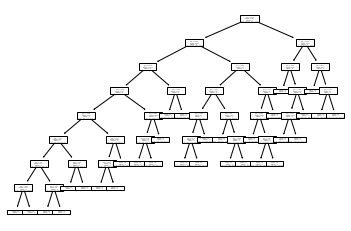

In [65]:
# Include decision tree visualization here
tree.plot_tree(clf)
# Discuss what the model has learned

## 6. (optional 5% extra credit) Implement reduced error pruning to help avoid overfitting.  
- You will need to take a validation set out of your training data to do this, while still having a test set to test your final accuracy. 
- Create a table comparing your decision tree implementation's results on the cars and voting data sets with and without reduced error pruning. 
- This table should compare:
    - a) The # of nodes (including leaf nodes) and tree depth of the final decision trees 
    - b) The generalization (test set) accuracy. (For the unpruned 10-fold CV models, just use their average values in the table).